In [13]:
#Import Packages

from typing import Iterator, List, Union, Tuple
from datetime import datetime
from time import strftime
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.3.0
Num GPUs Available:  1


In [14]:
#Load in Data

#Images from precise measured places
df1=pd.read_csv("./20210602_mapping_key_filt_MIN.csv", encoding='utf-8') 
print(df1)

#Images from general average measurement
df2=pd.read_csv("./testdatakey_0425.csv", encoding='utf-8') 
df2_imagedirectory="./testdata_0425/images"
df2_imagelocation=[]
df2_hardnessarray=[]
for filename in os.listdir(df2_imagedirectory):
    df2_imagelocation.append(df2_imagedirectory+"/"+str(filename))
    hardness_value=filename.split("_")[0]
    df2_hardnessarray.append(float(hardness_value))
df2["hardness"]=df2_hardnessarray
df2["image_location"]=df2_imagelocation
print(df2)

#Images from noisy measurement
df3_temp=pd.read_csv("./Augmented_Images_key.csv", encoding='utf-8') 
df3_imagedirectory = './Augmented_Images_StdSize_PNG/'
imgs_augmented = []
data_augmented = []

hrr=5 #3 #Sampling Repetitions
for sampling_reps in range(hrr): #loop through all data to get 'hrr' hardnesses per image 
    original_num = df3_temp.shape[0]
    sample_size = 2000
    for i in range(sample_size):
        entry = df3_temp.iloc[i%original_num] #sample identity that augmented image is from
        img_temp = np.array(Image.open(df3_imagedirectory+str(i)+'.png'))
        imgs_augmented.append(img_temp)
        #Add it with the proper label to data_augmented
        entry['hardness'] = np.random.normal(loc=entry['H (GPa)'], scale=entry['H error'])
        entry['image_location'] = df3_imagedirectory+str(i)+'.png'
        data_augmented.append(entry)
    
imgs_augmented = np.asarray(imgs_augmented)
data_augmented = pd.DataFrame(data=data_augmented)
data_augmented['sample'] = data_augmented.index
df3 = data_augmented[['sample','hardness', 'image_location']].copy()
print(df3)

#Collate all data
one_reps = 100
two_reps = 10
df = df3
for i in range(one_reps):
    df = df.append(df1)
for j in range(two_reps):
    df = df.append(df2)
print(df)

stamp = strftime("%m_%d_%H_%M")
print(stamp)
df.to_csv('Dataset_Collated_'+stamp+'.csv', index=False)

    sample  hardness               image_location
0        1  4.127870   ./Sliced/images/HIC_02.png
1        2  4.465772   ./Sliced/images/HIC_03.png
2        3  4.414998   ./Sliced/images/HIC_04.png
3        4  4.531602   ./Sliced/images/HIC_05.png
4        5  5.369055   ./Sliced/images/HIC_06.png
..     ...       ...                          ...
89      90  4.793245  ./Sliced/images/HIC_134.png
90      91  2.992398  ./Sliced/images/HIC_135.png
91      92  4.198116  ./Sliced/images/HIC_136.png
92      93  3.601752  ./Sliced/images/HIC_138.png
93      94  4.205570  ./Sliced/images/HIC_139.png

[94 rows x 3 columns]
     sample  hardness                     image_location
0         1       2.5  ./testdata_0425/images/2.5_01.png
1         2       2.5  ./testdata_0425/images/2.5_02.png
2         3       2.5  ./testdata_0425/images/2.5_03.png
3         4       2.5  ./testdata_0425/images/2.5_04.png
4         5       2.5  ./testdata_0425/images/2.5_05.png
..      ...       ...              

C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


    sample  hardness                           image_location
0        0  4.298459     ./Augmented_Images_StdSize_PNG/0.png
1        1  3.651776     ./Augmented_Images_StdSize_PNG/1.png
2        2  5.292030     ./Augmented_Images_StdSize_PNG/2.png
3        3  5.529775     ./Augmented_Images_StdSize_PNG/3.png
4        4  5.152281     ./Augmented_Images_StdSize_PNG/4.png
..     ...       ...                                      ...
6        6  3.217727  ./Augmented_Images_StdSize_PNG/1995.png
7        7  3.510048  ./Augmented_Images_StdSize_PNG/1996.png
8        8  3.195983  ./Augmented_Images_StdSize_PNG/1997.png
9        9  3.782275  ./Augmented_Images_StdSize_PNG/1998.png
10      10  2.991410  ./Augmented_Images_StdSize_PNG/1999.png

[10000 rows x 3 columns]
     sample  hardness                        image_location
0         0  4.298459  ./Augmented_Images_StdSize_PNG/0.png
1         1  3.651776  ./Augmented_Images_StdSize_PNG/1.png
2         2  5.292030  ./Augmented_Images_StdSize_

(array([  2.,   1.,   1.,   0.,   1.,   4., 256.,   5., 261.,  16., 279.,
         28., 243., 286.,  64., 411.,  66., 199., 213., 101., 128., 140.,
        258., 186., 159., 185., 179., 280., 258., 277., 386., 359., 270.,
        158., 138., 113., 339., 218., 240., 418., 123., 224., 558., 693.,
        274., 479., 470., 370., 451., 250., 458., 151., 341., 338., 241.,
        443., 926., 348., 458., 386., 384., 276., 212., 217., 245., 160.,
        392., 375., 282., 218., 379., 347., 460., 231., 409., 258., 470.,
        196., 210., 372., 161., 351., 153., 106., 102.,  97.,  84.,  67.,
        289.,  45.,  20.,  12.,  13.,   7.,   9.,   6.,   1.,   2.,   1.,
          3.]),
 array([2.22749575, 2.27133971, 2.31518368, 2.35902765, 2.40287161,
        2.44671558, 2.49055955, 2.53440351, 2.57824748, 2.62209144,
        2.66593541, 2.70977938, 2.75362334, 2.79746731, 2.84131127,
        2.88515524, 2.92899921, 2.97284317, 3.01668714, 3.0605311 ,
        3.10437507, 3.14821904, 3.192063  , 3.

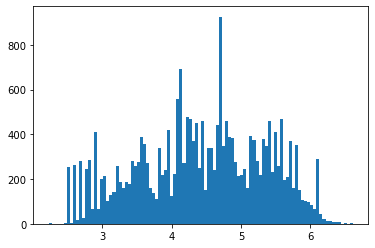

In [15]:
plt.hist(df["hardness"], 100)

       sample  hardness                        image_location
0           0  4.298459  ./Augmented_Images_StdSize_PNG/0.png
1           1  3.651776  ./Augmented_Images_StdSize_PNG/1.png
2           2  5.292030  ./Augmented_Images_StdSize_PNG/2.png
3           3  5.529775  ./Augmented_Images_StdSize_PNG/3.png
4           4  5.152281  ./Augmented_Images_StdSize_PNG/4.png
...       ...       ...                                   ...
22725     329  6.100000     ./testdata_0425/images/6.1_21.png
22726     330  6.100000     ./testdata_0425/images/6.1_22.png
22727     331  6.100000     ./testdata_0425/images/6.1_23.png
22728     332  6.100000     ./testdata_0425/images/6.1_24.png
22729     333  6.100000     ./testdata_0425/images/6.1_25.png

[22730 rows x 3 columns]


(array([  2.,   1.,   1.,   0.,   1.,   4., 256.,   5., 261.,  16., 279.,
         28., 243., 286.,  64., 411.,  66., 199., 213., 101., 128., 140.,
        258., 186., 159., 185., 179., 280., 258., 277., 386., 359., 270.,
        158., 138., 113., 339., 218., 240., 418., 123., 224., 558., 693.,
        274., 479., 470., 370., 451., 250., 458., 151., 341., 338., 241.,
        443., 926., 348., 458., 386., 384., 276., 212., 217., 245., 160.,
        392., 375., 282., 218., 379., 347., 460., 231., 409., 258., 470.,
        196., 210., 372., 161., 351., 153., 106., 102.,  97.,  84.,  67.,
        289.,  45.,  20.,  12.,  13.,   7.,   9.,   6.,   1.,   2.,   1.,
          3.]),
 array([2.22749575, 2.27133971, 2.31518368, 2.35902765, 2.40287161,
        2.44671558, 2.49055955, 2.53440351, 2.57824748, 2.62209144,
        2.66593541, 2.70977938, 2.75362334, 2.79746731, 2.84131127,
        2.88515524, 2.92899921, 2.97284317, 3.01668714, 3.0605311 ,
        3.10437507, 3.14821904, 3.192063  , 3.

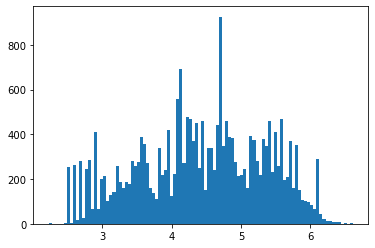

In [16]:
#Load Dataset
df_load = pd.read_csv ('Dataset_Collated_'+stamp+'.csv')
print(df_load)

#Visualize Data Labels
plt.hist(df_load["hardness"], 100)

In [ ]:
#end

In [1]:
from platform import python_version

print(python_version())

3.8.12
